In [1]:
%load_ext autoreload
%autoreload 2

import sys
import copy
import math
import pickle

sys.path.append("../../")

import numpy as np
import torch
import matplotlib.pyplot as plt

import implicitmodules.torch as dm

#torch.set_num_threads(6)
torch.set_default_tensor_type(torch.FloatTensor)

In [2]:
epsilon = .5
a = 10.
b = 1.
d = 1.
c = 41.
c0 = 40.
shape_rigid0 = torch.tensor([[0., 0.], [c0, 0.], [c0, a], [0., a], [0., 0.]])
shape_growth0 = torch .tensor([[0., a], [c0, a], [c0, a + b], [0., a + b], [0., a]])

shape_rigid = torch.tensor([[-epsilon, -epsilon], [c + epsilon, -epsilon], [c + epsilon, a +epsilon], [- epsilon, a + epsilon], [-epsilon, -epsilon]])
shape_growth = torch .tensor([[-epsilon, a-epsilon + d], [c+epsilon, a-epsilon + d], [c+epsilon, a + b+epsilon + d], [-epsilon, a + b+epsilon + d], [-epsilon, a-epsilon + d]])


In [3]:
Nh = 40
Nvr = 10
Nvg = 2
Xr0 = torch.stack([torch.linspace(0., c0, Nh), torch.zeros([Nh])]).t()
Xr1 = torch.stack([torch.linspace(c0, 0., Nh), torch.zeros([Nh]) + a]).t()
Yr0 = torch.stack([torch.zeros([Nvr]) + c0, torch.linspace(0., a, Nvr)]).t()
Yr1 = torch.stack([torch.zeros([Nvr]), torch.linspace(a, 0., Nvr)]).t()

Xg0 = torch.stack([torch.linspace(0., c0, Nh), torch.zeros([Nh]) + a]).t()
Xg1 = torch.stack([torch.linspace(c0, 0., Nh), torch.zeros([Nh]) + a + b]).t()
Yg0 = torch.stack([torch.zeros([Nvr]) + c0, torch.linspace(a, a + b, Nvr)]).t()
Yg1 = torch.stack([torch.zeros([Nvr]), torch.linspace(a + b, a, Nvr)]).t()

shape_rigid0 = torch.cat([Xr0, Yr0, Xr1, Yr1], dim=0)
shape_growth0 = torch.cat([Xg0, Yg0, Xg1, Yg1], dim=0)

(-2.6, 43.6, -1.15, 13.15)

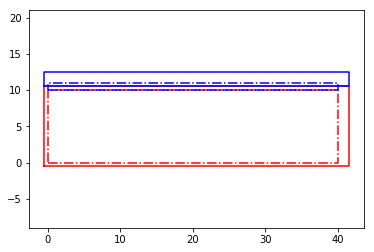

In [4]:
plt.figure()
plt.plot(shape_rigid[:,0], shape_rigid[:,1 ], '-r')
plt.plot(shape_rigid0[:,0], shape_rigid0[:,1 ], '-.r')
plt.plot(shape_growth[:,0], shape_growth[:,1 ], '-b')
plt.plot(shape_growth0[:,0], shape_growth0[:,1 ], '-.b')
plt.axis('equal')

In [5]:
aabb_rigid = dm.Utilities.AABB.build_from_points(shape_rigid)
aabb_growth = dm.Utilities.AABB.build_from_points(shape_growth)

In [6]:
density_rigid = 0.5
density_growth = 0.5

pts_rigid = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_rigid, density_rigid, shape=shape_rigid, side=1)
print(pts_rigid.shape)
pts_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_growth, density_growth, shape=shape_growth, side=1)
print(pts_growth.shape)

torch.Size([240, 2])
torch.Size([60, 2])


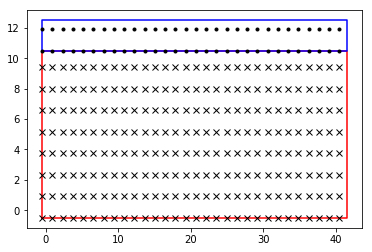

In [7]:
plt.figure()
plt.plot(shape_rigid[:,0], shape_rigid[:,1 ], '-r')
plt.plot(shape_growth[:,0], shape_growth[:,1 ], '-b')
plt.plot(pts_rigid[:,0], pts_rigid[:,1], 'xk')
plt.plot(pts_growth[:,0], pts_growth[:,1], '.k')

(-2.550609588623047,
 42.562801361083984,
 -1.1207106590270997,
 12.534923839569093)

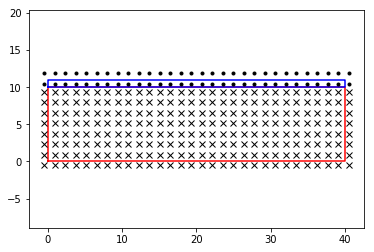

In [8]:
#%matplotlib qt5
plt.figure()
plt.plot(shape_rigid0[:,0], shape_rigid0[:,1 ], '-r')
plt.plot(shape_growth0[:,0], shape_growth0[:,1 ], '-b')
plt.plot(pts_rigid[:,0], pts_rigid[:,1], 'xk')
plt.plot(pts_growth[:,0], pts_growth[:,1], '.k')
plt.axis('equal')

(-2.550609588623047,
 42.562801361083984,
 -1.1207106590270997,
 12.534923839569093)

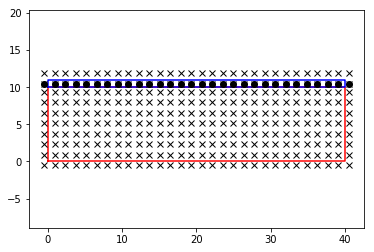

In [9]:
N_rigid = pts_rigid.shape[0]
N_growth = pts_growth.shape[0]
pts_implicit1 = torch.cat([pts_rigid, pts_growth], dim=0)
plt.figure()
plt.plot(shape_rigid0[:,0], shape_rigid0[:,1 ], '-r')
plt.plot(shape_growth0[:,0], shape_growth0[:,1 ], '-b')
plt.plot(pts_implicit1[:,0], pts_implicit1[:,1], 'xk')
#plt.plot(pts_implicit1[:N_rigid,0], pts_implicit1[:N_rigid,1], 'ok')
plt.plot(pts_implicit1[N_rigid::2,0], pts_implicit1[N_rigid::2,1], 'ok')
plt.axis('equal')

In [60]:
import math

dimC = 2
Npers = [0., 0.5, 1, 2, 3]
#Npers = [2]
C = torch.zeros(pts_implicit1.shape[0], 2, len(Npers))

for i in range(len(Npers)):
    Nper = Npers[i]
    theta = Nper * torch.linspace(0, 2 * math.pi, int(0.5 * N_growth))
    C[N_rigid::2, 0, i] = torch.tensor([math.cos(thetai) for thetai in theta])
    C[N_rigid+1::2, 0, i] = torch.tensor([math.cos(thetai) for thetai in theta])

In [61]:
C.shape

torch.Size([300, 2, 5])

In [62]:
%matplotlib qt5
ax_left = plt.subplot(1, 1, 1)
plt.plot(shape_rigid0[:,0], shape_rigid0[:,1 ], '-r')
plt.plot(shape_growth0[:,0], shape_growth0[:,1 ], '-b')
plt.plot(pts_implicit1[:,0], pts_implicit1[:,1], 'xk')
#plt.plot(pts_implicit1[:N_rigid,0], pts_implicit1[:N_rigid,1], 'ok')
dm.Utilities.plot_C_ellipse(ax_left, pts_implicit1, C, c_index=0, scale=0.5, color='red')
plt.axis('equal')

(-2.550609588623047,
 42.562801361083984,
 -1.1207106590270997,
 12.534923839569093)

In [63]:
angles = 0. * math.pi * torch.ones(pts_implicit1.shape[0])
R = torch.stack([dm.Utilities.rot2d(a) for a in angles])

In [124]:
cotan_pts = torch.zeros_like(pts_implicit1)
mm = 1000.
cotan_pts[-1, 0] = mm
cotan_pts[-1, 1] = mm

cotan_pts[N_rigid + 20, 1] = -mm
cotan_pts[N_rigid + 40, 1] = -mm

cotan_pts[N_rigid + 1, 0] = -mm
cotan_pts[N_rigid + 1, 1] = mm
#cotan_pts = 200 * (torch.rand_like(pts_implicit1) - 0.7)
cotan_R = torch.zeros_like(R)

In [125]:
sigma1 = 3.
nu = 0.001
implicit1 = dm.DeformationModules.create_deformation_module('implicit_order_1', dim=2, nb_pts=pts_implicit1.shape[0], C=C, sigma=sigma1, nu=nu, coeff=1., gd=(pts_implicit1.view(-1).requires_grad_(), R.view(-1).requires_grad_()), cotan = (cotan_pts.view(-1).requires_grad_(), cotan_R.view(-1).requires_grad_()))

In [126]:
silent_imp = dm.DeformationModules.create_deformation_module('silent_points', dim=2, nb_pts=pts_implicit1.shape[0], gd=pts_implicit1.view(-1).requires_grad_())
silent_rigid = dm.DeformationModules.create_deformation_module('silent_points', dim=2, nb_pts=shape_rigid0.shape[0], gd=shape_rigid0.view(-1).requires_grad_())
silent_growth = dm.DeformationModules.create_deformation_module('silent_points', dim=2, nb_pts=shape_growth0.shape[0], gd=shape_growth0.view(-1).requires_grad_())

In [127]:
intermediate_states, intermediate_controls = dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian([implicit1, silent_rigid, silent_growth]), 10, 'euler', intermediates=True)
pts = implicit1.manifold.gd[0].detach().view(-1, 2)
pts_rigid = silent_rigid.manifold.gd.detach().view(-1, 2)
pts_growth = silent_growth.manifold.gd.detach().view(-1, 2)

step  10


In [128]:
%matplotlib qt5
ax_left = plt.subplot(1, 1, 1)
plt.plot(shape_rigid0[:,0], shape_rigid0[:,1 ], '--r')
plt.plot(shape_growth0[:,0], shape_growth0[:,1 ], '--b')
#plt.plot(pts_implicit1[:,0], pts_implicit1[:,1], '.k')
plt.plot(pts_rigid[:,0], pts_rigid[:,1], '-r')
plt.plot(pts_growth[:,0], pts_growth[:,1], '-b')
plt.quiver(pts_implicit1[:,0], pts_implicit1[:,1], cotan_pts[:,0], cotan_pts[:,1])
plt.plot(pts[:,0], pts[:,1], '+r')
#plt.plot(pts_imp[:,0], pts_imp[:,1], 'xk')
plt.axis('equal')

(-6.50185546875, 46.221841430664064, -2.9991226315498354, 15.999920618534087)

In [129]:
print(intermediate_controls)

[[tensor([0.3651, 0.0300, 1.4288, 0.9516, 0.2766]), tensor([]), tensor([])], [tensor([0.3073, 0.0287, 1.3082, 0.8366, 0.1618]), tensor([]), tensor([])], [tensor([0.2711, 0.0277, 1.2331, 0.7576, 0.0718]), tensor([]), tensor([])], [tensor([ 0.2410,  0.0271,  1.1902,  0.7001, -0.0133]), tensor([]), tensor([])], [tensor([ 0.1957,  0.0257,  1.1724,  0.6544, -0.1080]), tensor([]), tensor([])], [tensor([ 0.1444,  0.0237,  1.1889,  0.6333, -0.1927]), tensor([]), tensor([])], [tensor([ 0.1085,  0.0199,  1.2252,  0.6259, -0.2772]), tensor([]), tensor([])], [tensor([ 0.0700,  0.0100,  1.2026,  0.5640, -0.4236]), tensor([]), tensor([])], [tensor([-0.0226,  0.0029,  1.0509,  0.3714, -0.7199]), tensor([]), tensor([])], [tensor([-0.1002,  0.0149,  0.9569,  0.1591, -1.0699]), tensor([]), tensor([])]]


In [136]:
cont = [] 
keep_cont = [True, True, False, True, True]

for i in range(10):
    cont_i = []
    for j in range(len(keep_cont)):
        if keep_cont[j]:
            cont_i.append(intermediate_controls[i][0][j].clone())
        else:
                cont_i.append(torch.zeros_like(intermediate_controls[i][0][j].clone()))
    cont.append([torch.tensor(cont_i), torch.tensor([]), torch.tensor([])])

In [137]:
implicit1_rg = dm.DeformationModules.create_deformation_module('implicit_order_1', dim=2, nb_pts=pts_implicit1.shape[0], C=C, sigma=sigma1, nu=nu, coeff=1., gd=(pts_implicit1.view(-1).requires_grad_(), R.view(-1).requires_grad_()), cotan = (cotan_pts.view(-1).requires_grad_(), cotan_R.view(-1).requires_grad_()))
silent_rigid_rg = dm.DeformationModules.create_deformation_module('silent_points', dim=2, nb_pts=shape_rigid0.shape[0], gd=shape_rigid0.view(-1).requires_grad_())
silent_growth_rg = dm.DeformationModules.create_deformation_module('silent_points', dim=2, nb_pts=shape_growth0.shape[0], gd=shape_growth0.view(-1).requires_grad_())

In [138]:
print(cont)

[[tensor([0.3651, 0.0300, 0.0000, 0.9516, 0.2766]), tensor([]), tensor([])], [tensor([0.3073, 0.0287, 0.0000, 0.8366, 0.1618]), tensor([]), tensor([])], [tensor([0.2711, 0.0277, 0.0000, 0.7576, 0.0718]), tensor([]), tensor([])], [tensor([ 0.2410,  0.0271,  0.0000,  0.7001, -0.0133]), tensor([]), tensor([])], [tensor([ 0.1957,  0.0257,  0.0000,  0.6544, -0.1080]), tensor([]), tensor([])], [tensor([ 0.1444,  0.0237,  0.0000,  0.6333, -0.1927]), tensor([]), tensor([])], [tensor([ 0.1085,  0.0199,  0.0000,  0.6259, -0.2772]), tensor([]), tensor([])], [tensor([ 0.0700,  0.0100,  0.0000,  0.5640, -0.4236]), tensor([]), tensor([])], [tensor([-0.0226,  0.0029,  0.0000,  0.3714, -0.7199]), tensor([]), tensor([])], [tensor([-0.1002,  0.0149,  0.0000,  0.1591, -1.0699]), tensor([]), tensor([])]]


In [139]:
intermediate_states_rg, intermediate_controls_rg = dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian([implicit1_rg, silent_rigid_rg, silent_growth_rg]), 10, 'euler', controls= cont, intermediates=True)
pts_rg = implicit1_rg.manifold.gd[0].detach().view(-1, 2)
pts_rigid_rg = silent_rigid_rg.manifold.gd.detach().view(-1, 2)
pts_growth_rg = silent_growth_rg.manifold.gd.detach().view(-1, 2)

step  10


In [140]:
%matplotlib qt5
ax_left = plt.subplot(1, 1, 1)
#plt.plot(shape_rigid0[:,0], shape_rigid0[:,1 ], '--r')
#plt.plot(shape_growth0[:,0], shape_growth0[:,1 ], '--b')
#plt.plot(pts_implicit1[:,0], pts_implicit1[:,1], '.k')
plt.plot(pts_rigid[:,0], pts_rigid[:,1], '--r')
plt.plot(pts_growth[:,0], pts_growth[:,1], '--b')
#plt.plot(pts[:,0], pts[:,1], '.r')

plt.plot(pts_rigid_rg[:,0], pts_rigid_rg[:,1], '-r')
plt.plot(pts_growth_rg[:,0], pts_growth_rg[:,1], '-b')
#plt.plot(pts_rg[:,0], pts_rg[:,1], 'xr')
#plt.plot(pts_imp[:,0], pts_imp[:,1], 'xk')
plt.axis('equal')

(-6.50185546875, 46.221841430664064, -2.437133699655533, 15.12412479519844)

In [50]:
t = 0
h = intermediate_controls[t][0]
C_t = torch.tensordot(C, h, dims=1).view(-1, 2, 1)

X = intermediate_states_rg[t].gd[0][0].view(-1,2)

In [57]:
%matplotlib qt5
ax_left = plt.subplot(1, 1, 1)
#plt.plot(shape_rigid0[:,0], shape_rigid0[:,1 ], '-r')
#plt.plot(shape_growth0[:,0], shape_growth0[:,1 ], '-b')
plt.plot(X[:,0], X[:,1], 'xk')
#plt.plot(pts_implicit1[:N_rigid,0], pts_implicit1[:N_rigid,1], 'ok')
dm.Utilities.plot_C_arrow(ax_left, X, C_t, c_index=0, scale=1., color='red', zorder=3, mutation_scale=10)
plt.axis('equal')

(-4.21357735771785, 44.17066861610501, -1.1244053653308328, 12.612512671947478)

In [120]:
# Source/target : implicit points
target_noisefree = implicit1.manifold.gd[0].detach().view(-1, 2)
source_pts = pts_implicit1.clone()
target_pts = target_noisefree #+ 0.2*torch.rand(*target_noisefree.shape)

In [25]:
# Source/target : surrounding shape
target_noisefree = torch.cat([pts_rigid.clone(), pts_growth.clone()], dim=0)
source_pts = torch.cat([shape_rigid0.clone(), shape_growth0.clone()], dim=0)
target_pts = target_noisefree + 0.2*torch.rand(*target_noisefree.shape)

In [36]:
target_noisefree.shape

torch.Size([300, 2])

In [121]:
%matplotlib qt5
ax_left = plt.subplot(1, 1, 1)
#plt.plot(pts_implicit1[:,0], pts_implicit1[:,1], '.k')
plt.plot(target_noisefree[:,0], target_noisefree[:,1], '.r')
plt.plot(target_pts[:,0], target_pts[:,1], '+r')
plt.axis('equal')

(-4.105070817470551, 44.1172590136528, -2.2467434406280518, 13.944256067276001)

In [122]:
implicit1_opt = dm.DeformationModules.create_deformation_module('implicit_order_1', dim=2, nb_pts=pts_implicit1.shape[0], C=C, sigma=sigma1, nu=nu, coeff=1., gd=(pts_implicit1.view(-1).requires_grad_(), R.view(-1).requires_grad_()))

In [123]:
#implicit0_opt = dm.DeformationModules.create_deformation_module('implicit_order_0', dim=2, nb_pts=pts_implicit1.shape[0], sigma=sigma1, nu=nu, coeff=10., gd=pts_implicit1.clone().view(-1).requires_grad_())

In [124]:
model = dm.Models.ModelPointsRegistration([source_pts], [implicit1_opt], [dm.Attachment.EuclideanPointwiseDistanceAttachment(weight=1.)], lam=100.)

In [125]:
fitter = dm.Models.ModelFittingScipy(model, 1.)

In [126]:
costs = fitter.fit([target_pts], 30, log_interval=1)

step  10
Initial energy = 29510.146
step  10
step  10
step  10
step  10
step  10
step  10
Iteration: 1 
Total energy = 6537.892090 
Attach cost = 5881.931152 
Deformation cost = 655.961060
step  10
Iteration: 2 
Total energy = 6044.345215 
Attach cost = 5134.143555 
Deformation cost = 910.201782
step  10
Iteration: 3 
Total energy = 4767.409180 
Attach cost = 3941.958984 
Deformation cost = 825.450439
step  10
step  10
Iteration: 4 
Total energy = 2724.927246 
Attach cost = 1907.836548 
Deformation cost = 817.090698
step  10
step  10
Iteration: 5 
Total energy = 2288.507324 
Attach cost = 1402.951294 
Deformation cost = 885.555908
step  10
step  10
Iteration: 6 
Total energy = 1406.734863 
Attach cost = 414.091248 
Deformation cost = 992.643555
step  10
step  10
step  10
Iteration: 7 
Total energy = 1273.980713 
Attach cost = 260.289154 
Deformation cost = 1013.691528
step  10
step  10
Iteration: 8 
Total energy = 1088.724731 
Attach cost = 82.521652 
Deformation cost = 1006.203064
ste

In [127]:
compound = dm.DeformationModules.CompoundModule(model.modules)
compound.manifold.fill(model.init_manifold)

In [128]:
intermediate_states_opt, intermediate_controls_opt = dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian(compound), 10, 'euler', intermediates=True)

step  10


In [129]:
pts = compound.manifold.gd[0].detach().view(-1, 2)

In [130]:
%matplotlib qt5
ax_left = plt.subplot(1, 1, 1)
#plt.plot(shape_rigid0[:,0], shape_rigid0[:,1 ], '--r')
#plt.plot(shape_growth0[:,0], shape_growth0[:,1 ], '--b')
#plt.plot(pts_implicit1[:,0], pts_implicit1[:,1], '.k')
#plt.plot(pts_rigid[:,0], pts_rigid[:,1], '-r')
#plt.plot(pts_growth[:,0], pts_growth[:,1], '-b')
#plt.quiver(pts_implicit1[:,0], pts_implicit1[:,1], cotan_pts[:,0], cotan_pts[:,1])
plt.plot(pts[:,0], pts[:,1], '+r')
plt.plot(target_pts[:,0], target_pts[:,1], 'xk')
plt.plot(target_noisefree[:,0], target_noisefree[:,1], 'xb')


plt.axis('equal')

(-4.105070817470551, 44.1172590136528, -2.246743583679199, 13.944259071350098)

In [131]:
print(intermediate_controls_opt)

[[tensor([]), tensor([0.4246, 0.3362])], [tensor([]), tensor([0.4213, 0.3355])], [tensor([]), tensor([0.4177, 0.3343])], [tensor([]), tensor([0.4138, 0.3327])], [tensor([]), tensor([0.4097, 0.3306])], [tensor([]), tensor([0.4055, 0.3280])], [tensor([]), tensor([0.4011, 0.3251])], [tensor([]), tensor([0.3966, 0.3217])], [tensor([]), tensor([0.3921, 0.3180])], [tensor([]), tensor([0.3877, 0.3141])]]


In [132]:
print(intermediate_controls)

[[tensor([0.4259, 0.3399]), tensor([]), tensor([])], [tensor([0.4201, 0.3365]), tensor([]), tensor([])], [tensor([0.4150, 0.3332]), tensor([]), tensor([])], [tensor([0.4104, 0.3303]), tensor([]), tensor([])], [tensor([0.4064, 0.3278]), tensor([]), tensor([])], [tensor([0.4030, 0.3255]), tensor([]), tensor([])], [tensor([0.4003, 0.3235]), tensor([]), tensor([])], [tensor([0.3980, 0.3218]), tensor([]), tensor([])], [tensor([0.3962, 0.3200]), tensor([]), tensor([])], [tensor([0.3948, 0.3179]), tensor([]), tensor([])]]


In [133]:
t = 5

In [134]:
h = intermediate_controls[t][0]
print(h)
C_t = torch.tensordot(C, h, dims=1).view(-1, 2, 1)

tensor([0.4030, 0.3255])


In [135]:
h_opt = intermediate_controls_opt[t][1]
print(h_opt)
C_opt_t = torch.tensordot(C, h_opt, dims=1).view(-1, 2, 1)

tensor([0.4055, 0.3280])


In [82]:
torch.max(torch.abs(C_t))

tensor(0.7299)

In [83]:
torch.max(torch.abs(C_t - C_opt_t))

tensor(0.1641)

In [110]:
t = 9
target_t = intermediate_states[t].gd[0][0].view(-1,2)
reached_t = intermediate_states_opt[t].gd[1][0].view(-1,2)

In [112]:
plt.figure()
plt.plot(target_t[:,0], target_t[:,1], '.b')
plt.plot(reached_t[:,0], reached_t[:,1], '.r')
plt.axis('equal')

(-4.149214178323746,
 44.16139867901802,
 -2.2784684121608736,
 14.028443259000777)